# Training HoVer-Net

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm

In [2]:
import os
os.chdir("./..")

In [3]:
%load_ext autoreload
%autoreload 2

In [43]:
# pannuke
from pathml.datasets.pannuke import PanNukeDataModule

pannuke = PanNukeDataModule(data_dir="./data/pannuke/", nucleus_type_labels=True, 
                            batch_size=2, hovernet_preprocess=True)
pannuke_train = pannuke.train_dataloader

In [60]:
im_batch, mask_batch, hv_batch, tissue_types_batch = next(iter(pannuke_train))

In [61]:
print(f"Im batch shape:\t\t{im_batch.shape}")
print(f"Mask batch shape:\t{mask_batch.shape}")
print(f"hv map batch shape:\t{hv_batch.shape}")

Im batch shape:		torch.Size([2, 3, 256, 256])
Mask batch shape:	torch.Size([2, 6, 256, 256])
hv map batch shape:	torch.Size([2, 2, 256, 256])


In [46]:
def vis_batch(im_batch, mask_batch, hv_batch, tissue_types_batch, n = 4):
    """
    visualize the inputs to HoVer-Net
    """
    cm_ind = plt.cm.gist_earth
    cm_ind.set_bad(color='white')
    cm_cat = plt.cm.tab10
    cm_cat.set_bad(color='white')
    
    fig, ax = plt.subplots(nrows = n, ncols= 5, figsize = (12, 3*n))
    
    for i in range(n):
        # image
        ax[i, 0].imshow(im_batch.permute(0, 2, 3, 1)[i, ...])
        # individual nuclei
        individual = mask_batch[i, -1, ...] == 0
        ax[i, 1].imshow(individual, cmap = cm_ind, interpolation = "none")
        # nucleus types
        cat = mask_batch.argmax(dim=1)[i, ...]
        cat = np.ma.masked_where(cat == 5, cat)
        ax[i, 2].imshow(cat, cmap = cm_cat, interpolation = "none")
        ax[i, 3].imshow(hv_batch[i, 0, :, :], cmap = 'coolwarm', interpolation = "none")
        ax[i, 4].imshow(hv_batch[i, 1, :, :], cmap = 'coolwarm', interpolation = "none")
        
    ax[0, 0].set_title("RGB Image")
    ax[0, 1].set_title("Individual Nuclei")
    ax[0, 2].set_title("Nucleus Types")
    ax[0, 3].set_title("Horizontal Map")
    ax[0, 4].set_title("Vertical Map")
    for a in ax.ravel(): a.axis('off')
    
    plt.tight_layout()
    plt.show()

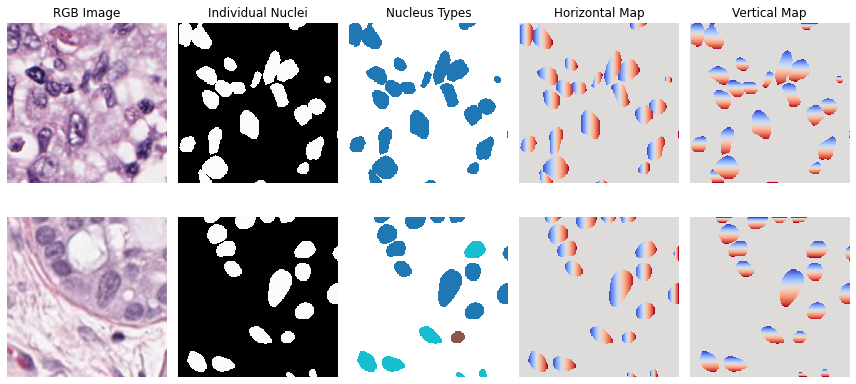

In [62]:
vis_batch(im_batch, mask_batch, hv_batch, tissue_types_batch, n = 2)

In [63]:
from pathml.ml.hovernet import _get_gradient_hv

hg, vg = _get_gradient_hv(hv_batch)
print(f"horizontal gradient shape:\t{hg.shape}")
print(f"vertical gradient shape:\t{vg.shape}")

horizontal gradient shape:	torch.Size([2, 1, 256, 256])
vertical gradient shape:	torch.Size([2, 1, 256, 256])


In [101]:
def vis_gradients(hv_batch, n=2):
    """
    Plot the horizontal, vertical maps alongside their gradients
    """
    hg, vg = _get_gradient_hv(hv_batch)
    
    fix, axarr = plt.subplots(nrows=n, ncols=4, figsize = (10, 3*n))

    for i in range(n):
        axarr[i, 0].imshow(hv_batch[i, 0, ...], cmap = 'coolwarm')
        axarr[i, 1].imshow(hg[i, 0, ...], vmin=-2, vmax=2, cmap = 'coolwarm')
        axarr[i, 2].imshow(hv_batch[i, 1, ...], cmap = 'coolwarm')
        axarr[i, 3].imshow(vg[i, 0, ...], vmin=-2, vmax=2, cmap = 'coolwarm')
    
    axarr[0, 0].set_title("Horizontal Map")
    axarr[0, 1].set_title("Horizontal Gradients")
    axarr[0, 2].set_title("Vertical Map")
    axarr[0, 3].set_title("Vertical Gradients")
    for a in axarr.ravel(): a.axis('off')
    
    plt.tight_layout()

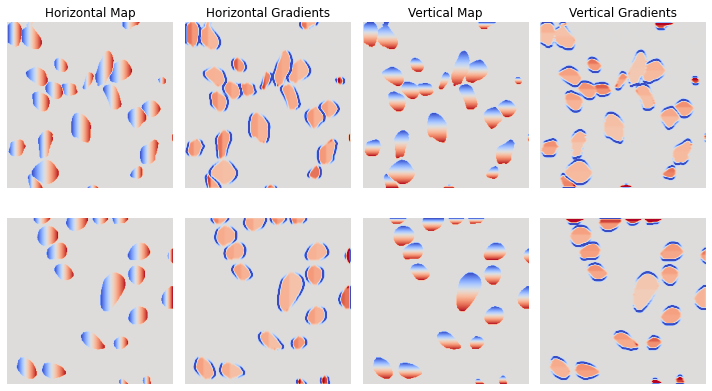

In [102]:
vis_gradients(hv_batch)
plt.show()

In [65]:
from pathml.ml.hovernet import HoverNet
hovernet = HoverNet(n_classes=6)

In [70]:
out = hovernet(im_batch.float())

In [71]:
np_out, hv_out, nc_out = out

In [72]:
print("input shapes")
for val, name in zip([im_batch, mask_batch], ["im", "mask"]):
    print(f"{name}:\t{val.shape}")
print("")
print("output shapes")
for val, name in zip(out, ["np_out", "hv_out", "nc_out"]):
    print(f"{name}:\t{val.shape}")

input shapes
im:	torch.Size([2, 3, 256, 256])
mask:	torch.Size([2, 6, 256, 256])

output shapes
np_out:	torch.Size([2, 2, 256, 256])
hv_out:	torch.Size([2, 2, 256, 256])
nc_out:	torch.Size([2, 6, 256, 256])


In [73]:
from pathml.ml.hovernet import loss_HoVerNet

loss = loss_HoVerNet(outputs = out, ground_truth = [mask_batch, hv_batch], n_classes=6)

print(f"loss for batch: {loss}")

loss for batch: 14.971837997436523


# Training loop on small batch

In [74]:
# set up training loop
n_epochs = 30

hovernet.train()
opt = torch.optim.Adam(hovernet.parameters(), lr = 1e-4)

losses = []

In [75]:
# run training loop
for i in tqdm(range(n_epochs)):
    opt.zero_grad()
    out = hovernet(im_batch.float())
    loss = loss_HoVerNet(outputs = out, ground_truth = [mask_batch, hv_batch], n_classes=6)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    

100%|██████████| 30/30 [36:01<00:00, 72.06s/it]


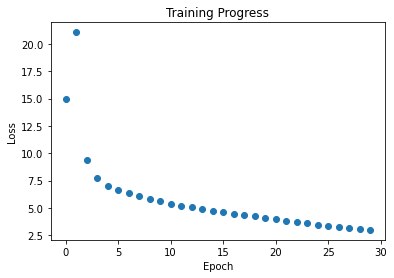

In [79]:
plt.scatter(x=np.arange(len(losses)), y = losses)
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [81]:
with torch.no_grad():
    preds_out_trained = hovernet(im_batch.float())

In [83]:
np_out_trained, hv_out_trained, nc_out_trained = preds_out_trained

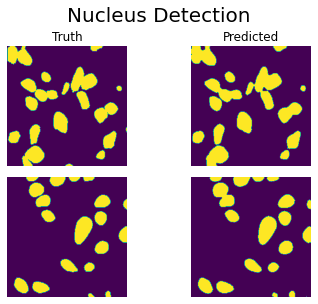

In [99]:
nucleus_preds = torch.softmax(np_out_trained, dim=1).argmax(dim=1)

fig, axarr = plt.subplots(nrows=2, ncols=2)
axarr[0, 0].imshow(mask_batch[0, -1, :, :] == 0)
axarr[0, 1].imshow(nucleus_preds[0, :, :])
axarr[1, 0].imshow(mask_batch[1, -1, :, :] == 0)
axarr[1, 1].imshow(nucleus_preds[1, :, :])

axarr[0, 0].set_title("Truth")
axarr[0, 1].set_title("Predicted")

for a in axarr.ravel():
    a.axis("off")

plt.suptitle("Nucleus Detection", fontsize = 20, va = "bottom")
plt.tight_layout()
plt.show()

In [137]:
def nucleus_class_preds(nucleus_class_preds, nucleus_binary_mask):
    """
    Take majority vote within each nucleus region
    
    Args:
        nucleus_class_preds: Tensor of shape (H, W) with predicted class label
        nucleus_binary_mask: Boolean Tensor of shape (H, W) indicating nucleus pixels
    """
    final_class_preds = nucleus_class_preds.detach().clone()

    # each contiguous nucleus region gets a unique id
    _, labels = cv2.connectedComponents(nucleus_binary_mask.numpy().astype(np.uint8))
    # go through each and do majority vote
    for i in np.unique(labels):
        mask_n = torch.Tensor(labels == i).type(torch.bool)
        class_preds_n = torch.masked_select(input = nucleus_class_preds, mask = mask_n)
        majority_vote, _ = torch.mode(class_preds_n)
        final_class_preds = final_class_preds.masked_fill(mask = mask_n, value = majority_vote)
    return final_class_preds

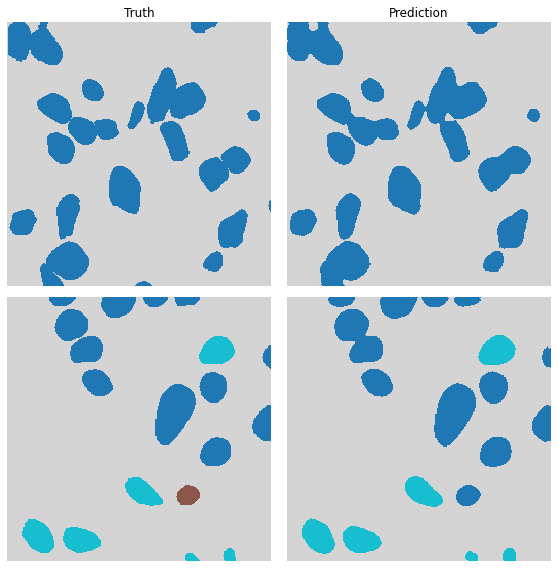

In [692]:
class_preds_trained = nc_out_trained.softmax(dim = 1).argmax(dim = 1)
nucleus_binary_mask_batch = np_out_trained.softmax(dim = 1).argmax(dim = 1) == 1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8,8))
cm_cat = plt.cm.tab10
cm_cat.set_bad(color='lightgrey')

for i in {0, 1}:    
    cat = mask_batch.argmax(dim=1)[i, ...]
    cat = np.ma.masked_where(cat == 5, cat)
    ax[i, 0].imshow(cat, cmap = cm_cat, interpolation = "none")
    
    maj_vote = nucleus_class_preds(class_preds_trained[i, ...], nucleus_binary_mask_batch[i, ...])
    maj_vote = np.ma.masked_where(maj_vote == 5, maj_vote)
    ax[i, 1].imshow(maj_vote, cmap = cm_cat, interpolation = "none")

ax[0, 0].set_title("Truth")
ax[0, 1].set_title("Prediction")

for a in ax.ravel():
    a.axis("off")


plt.tight_layout()
plt.show()

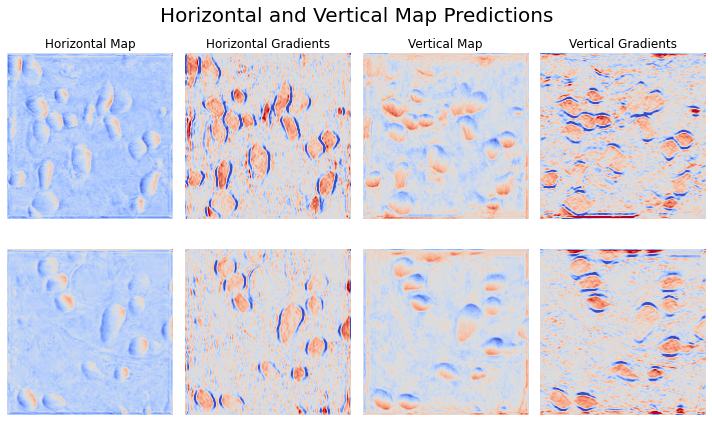

In [104]:
vis_gradients(hv_out_trained)
plt.suptitle("Horizontal and Vertical Map Predictions", fontsize = 20, va = "bottom")
plt.show()

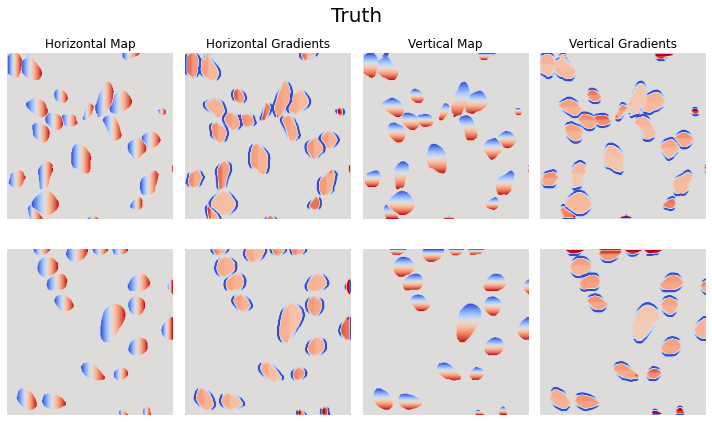

In [156]:
vis_gradients(hv_batch)
plt.suptitle("Truth", fontsize = 20, va = "bottom")
plt.show()

## Train HoVer-Net on PanNuke Dataset

In [ ]:
import torch
from pathml.datasets.pannuke import PanNukeDataModule
from pathml.ml.hovernet import HoverNet

In [75]:
# Load dataset
pannuke = PanNukeDataModule(data_dir="./data/pannuke/", nucleus_type_labels=True, 
                            batch_size=2, hovernet_preprocess=True)
pannuke_train = pannuke.train_dataloader

# Inititialize model
hovernet = HoverNet(n_classes=6)

# set up training loop
n_epochs = 30
hovernet.train()
opt = torch.optim.Adam(hovernet.parameters(), lr = 1e-4)
losses = []

# run training loop
for i in tqdm(range(n_epochs)):
    opt.zero_grad()
    out = hovernet(im_batch.float())
    loss = loss_HoVerNet(outputs = out, ground_truth = [mask_batch, hv_batch], n_classes=6)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    

100%|██████████| 30/30 [36:01<00:00, 72.06s/it]


## Post-process outputs

In [616]:
from pathml.ml.hovernet import post_process_batch_hovernet
detection_postproc, classification_postproc = post_process_batch_hovernet(preds_out_trained)

torch.Size([4, 3, 256, 256])
(4, 6, 256, 256)


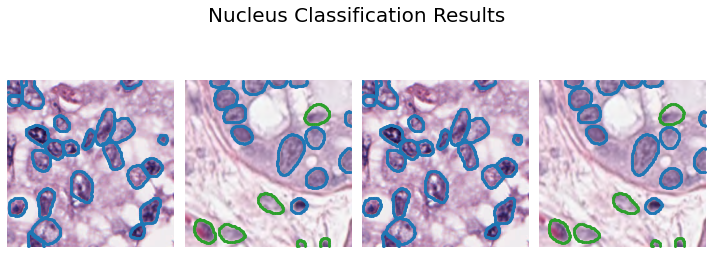

In [710]:
a = torch.cat([im_batch, im_batch])
b = np.concatenate([classification_postproc, classification_postproc])

vis_outputs(a, b, n_classes=6, markersize=8, n_images=4)

plt.suptitle("Nucleus Classification Results", fontsize = 20, va="bottom")
plt.show()

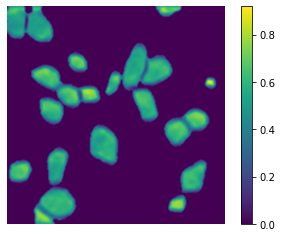

In [688]:
from pathml.ml.hovernet import _post_process_single_hovernet

o, e = _post_process_single_hovernet(
    np_out_trained[0, ...], hv_out_trained[0, ...], small_obj_size_thresh=10, kernel_size=21, h=0.5, k=0.5)

plt.imshow(-e)
plt.axis("off")
plt.colorbar()
plt.show()

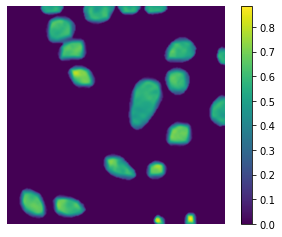

In [690]:
o, e = _post_process_single_hovernet(
    np_out_trained[1, ...], hv_out_trained[1, ...], small_obj_size_thresh=10, kernel_size=21, h=0.5, k=0.5)

plt.imshow(-e)
plt.axis("off")
plt.colorbar()
plt.show()